In [1]:
import sys

sys.path.append("../")

## Running the simulations

In [2]:
import scripts
import os

leaks_path = "../data/leaks"
reports_path = "../data/reports"
network_path = "../data/Hanoi.inp"

os.environ["EPANET_HOME"] = "../EPANET/build/bin/runepanet"

scripts.prepare_files(network_path, leaks_path)
scripts.run_simulations(leaks_path, reports_path)

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Hanoi.inp loaded successfully.

generating 32 input files...

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                       

## Reading the reports

In [6]:
import pandas as pd

def extract_node_id(path: str) -> int:
    normpath = os.path.normpath(path)
    filename = normpath.split("/")[-1]
    return int(filename.split("_")[0])

In [9]:
report_dir_path = "../data/reports"
filenames = os.listdir(report_dir_path)

report_paths = [os.path.join(report_dir_path, filename) for filename in filenames if not filename.startswith("baseline")]
reports = [(scripts.read_report(path), extract_node_id(path)) for path in report_paths]

baseline_report = scripts.read_report(os.path.join(report_dir_path, "baseline_1.rpt"))

# Baseline report is the report from the run that was run without the leakage

In [10]:
for i in range(1, len(baseline_report)):
    print((baseline_report[i-1] == baseline_report[i]).all())

pressure    True
dtype: bool
pressure    True
dtype: bool
pressure    True
dtype: bool


In [11]:
def report_to_pandas(report: list[pd.DataFrame], leakage_node: int) -> pd.DataFrame:

    training_example = []
    for i, pressure_measure in enumerate(report):
        pressure_measure = pressure_measure.T.reset_index(drop=True)
        pressure_measure.columns.name = None

        pressure_measure["ts"] = i
        pressure_measure["leakage_node"] = leakage_node

        training_example.append(pressure_measure)

    row_df = pd.concat(training_example)
    return row_df


def transform_whole_dataset(reports: list[tuple[list[pd.DataFrame], int]]) -> pd.DataFrame:
    report_dataframes = []

    for report in reports:
        report_dataframes.append(report_to_pandas(*report))

    df = pd.concat(report_dataframes).reset_index(drop=True)
    return df

In [12]:
df = transform_whole_dataset(reports)
df

,2,3,4,5,6,7,8,9,10,11,...,26,27,28,29,30,31,32,1,ts,leakage_node
0,67.10,31.16,26.71,21.21,15.44,14.11,12.56,11.34,10.45,8.89,...,2.07,1.67,5.34,0.82,0.01,0.01,0.03,-0.0,0,32
1,66.95,28.99,23.74,17.22,10.27,8.61,6.57,5.55,4.83,3.56,...,0.99,0.09,4.55,0.49,0.04,0.26,1.02,-0.0,0,8
2,67.00,29.68,24.69,18.49,11.92,10.37,8.48,6.96,5.82,3.25,...,1.27,0.30,4.84,0.62,0.06,0.33,1.21,-0.0,0,12
3,67.00,29.68,24.69,18.49,11.92,10.37,8.48,6.96,5.82,3.25,...,1.27,0.30,4.84,0.62,0.06,0.33,1.21,-0.0,1,12
4,67.13,31.48,27.05,21.56,15.82,14.49,12.95,11.74,10.86,9.30,...,3.13,2.62,5.22,0.02,0.05,0.62,2.05,-0.0,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,67.08,30.89,26.43,20.92,15.14,13.80,12.24,11.01,10.12,8.56,...,1.26,0.92,5.02,0.69,0.04,0.21,0.85,-0.0,0,25
81,66.87,27.92,23.52,18.06,12.36,11.04,9.51,8.31,7.45,5.89,...,0.06,0.03,1.40,0.04,0.00,0.01,0.06,-0.0,0,23
82,66.87,27.92,23.52,18.06,12.36,11.04,9.51,8.31,7.45,5.89,...,0.06,0.03,1.40,0.04,0.00,0.01,0.06,-0.0,1,23
83,66.87,27.92,23.52,18.06,12.36,11.04,9.51,8.31,7.45,5.89,...,0.06,0.03,1.40,0.04,0.00,0.01,0.06,-0.0,2,23


In [13]:
baseline_pressures = report_to_pandas(baseline_report, -1)
baseline_pressures = baseline_pressures.iloc[[0]].drop(columns=["ts", "leakage_node"]).to_numpy()
ts, leakage_node = df["ts"], df["leakage_node"]
pressures = df.drop(columns=["ts", "leakage_node"]).to_numpy()

pressures = pressures - baseline_pressures # Following the the method from the paper, we subtract the baseline pressures from the measured pressures

## Reading the graph

In [14]:
from epyt import epanet

input_file = "../data/Hanoi.inp"
G = epanet(input_file)

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Hanoi.inp loaded successfully.



Computing distances between every node using Floyd-Warshall algorithm. Those distances are needed in evaluation function in Simulated Annealing.

In [17]:
import numba
import numpy as np

@numba.jit(nopython=True)
def triple_loop(dist: np.ndarray, n: int) -> np.ndarray:
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    return dist


def floyd_warshall(adj_matrix: np.ndarray, undirected: bool = True) -> np.ndarray:
    n = adj_matrix.shape[0]
    if undirected:
        adj_matrix = np.maximum(adj_matrix, adj_matrix.T)
        
    dist = np.full_like(adj_matrix, float(n + 1))
    dist[adj_matrix > 0] = 1.0
    np.fill_diagonal(dist, 0.0)

    dist = triple_loop(dist, n)
    return dist


def matrix_to_adj_list(matrix: np.ndarray, undirected: bool = True) -> list[set[int]]:
    n = matrix.shape[0]
    if undirected:
        matrix = np.maximum(matrix, matrix.T)

    adj_list = [set() for _ in range(n)]
    for i, row in enumerate(matrix):
        for neighbor, connected in enumerate(row):
            if connected > 0:
                adj_list[i].add(neighbor)
                adj_list[neighbor].add(i)

    return adj_list


class Network:
    def __init__(self, G: epanet):
        self.G = G

        self.adj_matrix = G.getAdjacencyMatrix()
        self.adj_list = matrix_to_adj_list(self.adj_matrix, undirected=True)
        self.distances = floyd_warshall(self.adj_matrix, undirected=True)

        self.node_ids = G.NodeNameID
        self.node_indexes = list(map(lambda x: x - 1, G.NodeIndex))
        self.node_id_to_position_mapping = dict(zip(G.NodeNameID, self.node_indexes))

    def plot_with_ids(self):
        self.G.plot(nodesID=self.node_ids, fontsize=3)

    def plot_with_indexes(self):
        self.G.plot(nodesindex=list(map(lambda x: x + 1, self.node_indexes)), fontsize=3)

    def neighbor_array(self, vertex: int) -> np.ndarray:
        return np.array(list(self.adj_list[vertex]))

    def map_node_ids(self, ids: np.ndarray) -> np.ndarray:
        ids = list(map(str, ids))
        return np.array(list(map(self.node_id_to_position_mapping.get, ids)))

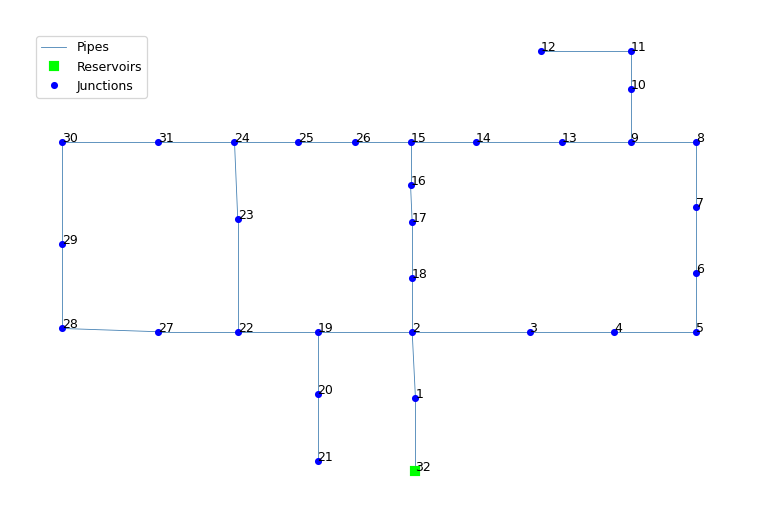

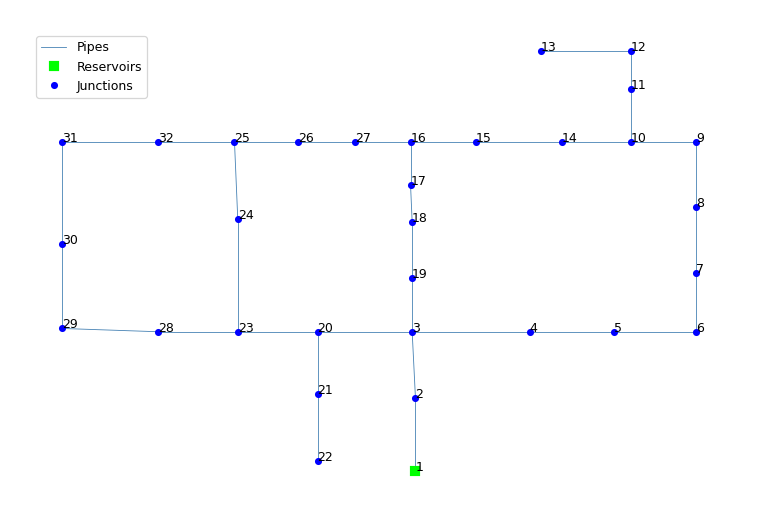

In [18]:
network = Network(G)
network.plot_with_indexes()
network.plot_with_ids()

## Simulated Annealing

Genrating random starting point

In [19]:
def random_solution(vertices: np.ndarray, m: int) -> np.ndarray:
    return np.random.permutation(vertices)[:m]

vertices = np.array(network.node_indexes)
solution = random_solution(vertices, 3)

Data split, training dataset is used to fit the KNN-classifier. The prediction on the test dataset is used in the evaluation function.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

leakage_node_mapped = network.map_node_ids(leakage_node)
train_pressures, test_pressures, train_labels, test_labels = train_test_split(pressures, leakage_node_mapped, test_size=0.5)

Function for the evaluation of the candidate solution

In [22]:
def evaluate_solution(
        vertices_subset: np.ndarray, 
        network: Network,
        train_pressures: np.ndarray,
        train_labels: np.ndarray,
        test_pressures: np.ndarray,
        test_labels: np.ndarray,
        d_max: float = 5
    ) -> float:

    train_subset = train_pressures[:, vertices_subset]
    test_subset = test_pressures[:, vertices_subset]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_subset, train_labels)

    pred_label = knn.predict(test_subset)

    dists = network.distances[pred_label, test_labels] / d_max
    dists[dists >= 1.0] = 1.0 
    loss = dists.sum() / pred_label.shape[0]

    return loss


solution = random_solution(vertices, 4)
print(solution)
evaluate_solution(solution, network, train_pressures, train_labels, test_pressures, test_labels)

[21 25  1 16]


np.float64(0.4976744186046511)

Neighbor generating function for the annealing.

In [24]:
def generate_neighbor(vertex_subset: np.ndarray, network: Network) -> np.ndarray:

    count = 0
    while count < 100:
        vertex_to_swap = np.random.choice(vertex_subset)
        neighboring_vertex = np.random.choice(network.neighbor_array(vertex_to_swap))
        if neighboring_vertex not in vertex_subset:
            break
        count += 1

    new_vertices = vertex_subset.copy()
    new_vertices[new_vertices == vertex_to_swap] = neighboring_vertex

    return new_vertices

In [25]:
generate_neighbor(solution, network)

array([21, 25, 17, 16])

### Annealing

In [34]:
from typing import Callable

def f(delta, T):
    return np.exp(-delta/T)

def annealing(
    vertices: np.ndarray,
    network: Network,
    train_pressures: np.ndarray,
    train_labels: np.ndarray,
    test_pressures: np.ndarray,
    test_labels: np.ndarray,
    neighbor_fun: Callable[[np.ndarray, Network], np.ndarray] = generate_neighbor,

    steps: int = 1000, 
    T0: int = 50, 
    alpha: float = 0.99, 
    no_of_iter: int = 40, 
) -> None:
    
    solution = random_solution(vertices, 5)
    cur_energy = evaluate_solution(
        solution, network, 
        train_pressures, train_labels,
        test_pressures, test_labels
    )

    energy_states = [cur_energy]
    T = T0
    temperature = [T0]

    for i in range(steps):
        for _ in range(no_of_iter):
            new_solution = neighbor_fun(solution, network)
            next_energy = evaluate_solution(
                new_solution, network,
                train_pressures, train_labels,
                test_pressures, test_labels
            )

            if next_energy < cur_energy:
                solution = new_solution
                cur_energy = next_energy
            else:
                probability = f(next_energy - cur_energy, T)
                if probability > np.random.uniform(0, 1):
                    solution = new_solution
                    cur_energy = next_energy

        T *= alpha
        temperature.append(T)
        energy_states.append(cur_energy)

    return energy_states, temperature

In [35]:
E, T = annealing(vertices, network, train_pressures, train_labels, test_pressures, test_labels)

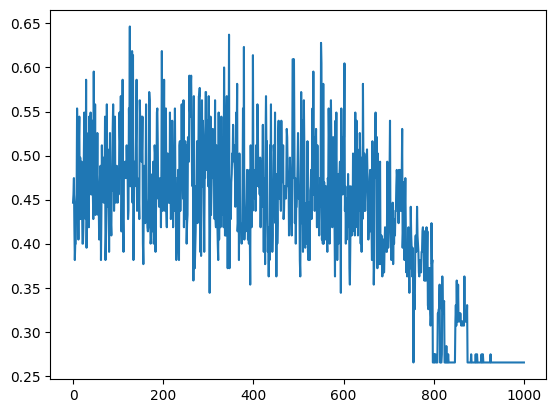

In [36]:
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.plot(E)
plt.show()

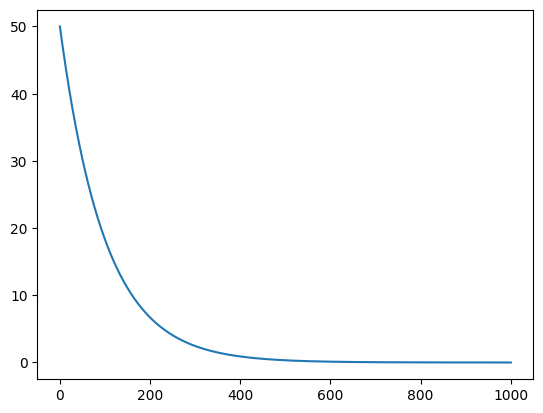

In [37]:
plt.plot(T)
plt.show()